In [3]:
# IPython candies...
from IPython.display import Image
from IPython.core.display import HTML

from IPython.display import clear_output

In [4]:
from collections import namedtuple

import numpy as np
from tqdm import tqdm

import pandas as pd

from gensim.corpora import Dictionary

import torch
from torch import nn, optim, tensor, autograd
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(12, 8)})


torch.manual_seed(42)

In [6]:
try: # Use the default NLTK tokenizer.
    from nltk import word_tokenize, sent_tokenize 
    # Testing whether it works. 
    # Sometimes it doesn't work on some machines because of setup issues.
    word_tokenize(sent_tokenize("This is a foobar sentence. Yes it is.")[0])
except: # Use a naive sentence tokenizer and toktok.
    import re
    from nltk.tokenize import ToktokTokenizer
    # See https://stackoverflow.com/a/25736515/610569
    sent_tokenize = lambda x: re.split(r'(?<=[^A-Z].[.?]) +(?=[A-Z])', x)
    # Use the toktok tokenizer that requires no dependencies.
    toktok = ToktokTokenizer()
    word_tokenize = word_tokenize = toktok.tokenize

In [7]:
import os
import requests
import io #codecs


# Text version of https://kilgarriff.co.uk/Publications/2005-K-lineer.pdf
if os.path.isfile('language-never-random.txt'):
    with io.open('language-never-random.txt', encoding='utf8') as fin:
        text = fin.read()
else:
    url = "https://gist.githubusercontent.com/alvations/53b01e4076573fea47c6057120bb017a/raw/b01ff96a5f76848450e648f35da6497ca9454e4a/language-never-random.txt"
    text = requests.get(url).content.decode('utf8')
    with io.open('language-never-random.txt', 'w', encoding='utf8') as fout:
        fout.write(text)

In [8]:
# Tokenize the text.
tokenized_text = [list(map(str.lower, word_tokenize(sent))) 
                  for sent in sent_tokenize(text)]

In [9]:
class KilgariffDataset(nn.Module):
    def __init__(self, texts):
        self.texts = texts
        
        # Initialize the vocab 
        special_tokens = {'<pad>': 0, '<unk>':1, '<s>':2, '</s>':3}
        self.vocab = Dictionary(texts)
        self.vocab.patch_with_special_tokens(special_tokens)
        
        # Keep track of the vocab size.
        self.vocab_size = len(self.vocab)
        
        # Keep track of how many data points.
        self._len = len(texts)
        
        # Find the longest text in the data.
        self.max_len = max(len(txt) for txt in texts) 
        
    def __getitem__(self, index):
        vectorized_sent = self.vectorize(self.texts[index])
        x_len = len(vectorized_sent)
        # To pad the sentence:
        # Pad left = 0; Pad right = max_len - len of sent.
        pad_dim = (0, self.max_len - len(vectorized_sent))
        vectorized_sent = F.pad(vectorized_sent, pad_dim, 'constant')
        return {'x':vectorized_sent[:-1], 
                'y':vectorized_sent[1:], 
                'x_len':x_len}
    
    def __len__(self):
        return self._len
    
    def vectorize(self, tokens, start_idx=2, end_idx=3):
        """
        :param tokens: Tokens that should be vectorized. 
        :type tokens: list(str)
        """
        # See https://radimrehurek.com/gensim/corpora/dictionary.html#gensim.corpora.dictionary.Dictionary.doc2idx 
        # Lets just cast list of indices into torch tensors directly =)
        
        vectorized_sent = [start_idx] + self.vocab.doc2idx(tokens) + [end_idx]
        return torch.tensor(vectorized_sent)
    
    def unvectorize(self, indices):
        """
        :param indices: Converts the indices back to tokens.
        :type tokens: list(int)
        """
        return [self.vocab[i] for i in indices]

In [10]:
kilgariff_data = KilgariffDataset(tokenized_text)
len(kilgariff_data.vocab)

1392

In [11]:
batch_size = 10
dataloader = DataLoader(dataset=kilgariff_data, batch_size=batch_size, shuffle=True)

for data_dict in dataloader:
    # Sort indices of data in batch by lengths.
    sorted_indices = np.array(data_dict['x_len']).argsort()[::-1].tolist()
    data_batch = {name:_tensor[sorted_indices]
                  for name, _tensor in data_dict.items()}
    print(data_batch)
    break

{'x': tensor([[   2,  184,  248,  ...,    0,    0,    0],
        [   2,  344,  327,  ...,    0,    0,    0],
        [   2,  269,   52,  ...,    0,    0,    0],
        ...,
        [   2,  994, 1388,  ...,    0,    0,    0],
        [   2,  747,  799,  ...,    0,    0,    0],
        [   2, 1206, 1389,  ...,    0,    0,    0]]), 'y': tensor([[ 184,  248,   73,  ...,    0,    0,    0],
        [ 344,  327,  392,  ...,    0,    0,    0],
        [ 269,   52,   35,  ...,    0,    0,    0],
        ...,
        [ 994, 1388, 1272,  ...,    0,    0,    0],
        [ 747,  799,  123,  ...,    0,    0,    0],
        [1206, 1389,    3,  ...,    0,    0,    0]]), 'x_len': tensor([40, 31, 27, 19, 18, 17, 16, 16, 14,  4])}


In [12]:
class Generator(nn.Module):
    def __init__(self, vocab_size, embedding_size, hidden_size, num_layers):
        super(Generator, self).__init__()

        # Initialize the embedding layer with the 
        # - size of input (i.e. no. of words in input vocab)
        # - no. of hidden nodes in the embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=0)
        
        # Initialize the GRU with the 
        # - size of the input (i.e. embedding layer)
        # - size of the hidden layer 
        self.gru = nn.GRU(embedding_size, hidden_size, num_layers, batch_first=True)
        
        # Initialize the "classifier" layer to map the RNN outputs
        # to the vocabulary. Remember we need to -1 because the 
        # vectorized sentence we left out one token for both x and y:
        # - size of hidden_size of the GRU output.
        # - size of vocabulary
        self.classifier = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs, use_softmax=False, hidden=None):
        # Look up for the embeddings for the input word indices.
        embedded = self.embedding(inputs)
        # Put the embedded inputs into the GRU.
        output, hidden = self.gru(embedded, hidden)
        
        # Matrix manipulation magic.
        batch_size, sequence_len, hidden_size = output.shape
        # Technically, linear layer takes a 2-D matrix as input, so more manipulation...
        output = output.contiguous().view(batch_size * sequence_len, hidden_size)
        # Apply dropout.
        output = F.dropout(output, 0.5)
        # Put it through the classifier
        # And reshape it to [batch_size x sequence_len x vocab_size]
        output = self.classifier(output).view(batch_size, sequence_len, -1)
        
        return (F.softmax(output,dim=2), hidden) if use_softmax else (output, hidden)
        


In [13]:
# Set the hidden_size of the GRU 
embed_size = 12
hidden_size = 10
num_layers = 1

_encoder = Generator(len(kilgariff_data.vocab), embed_size, hidden_size, num_layers)

In [14]:
# Take a batch.
batch_size = 15
dataloader = DataLoader(dataset=kilgariff_data, batch_size=batch_size, shuffle=True)

_batch = next(iter(dataloader))
_inputs, _lengths = _batch['x'], _batch['x_len']
_targets = _batch['y']

In [15]:
_output, _hidden = _encoder(_inputs)
print('Output sizes:\t', _output.shape)
print('Input sizes:\t', batch_size, kilgariff_data.max_len -1, len(kilgariff_data.vocab))
print('Target sizes:\t', _targets.shape)

Output sizes:	 torch.Size([15, 183, 1392])
Input sizes:	 15 183 1392
Target sizes:	 torch.Size([15, 183])


In [16]:
_output.shape

torch.Size([15, 183, 1392])

In [17]:
_output[-1].shape

torch.Size([183, 1392])

In [18]:
_, predicted_indices = torch.max(_output, dim=1)
print(predicted_indices.shape)


torch.Size([15, 1392])


In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

_hyper = ['embed_size', 'hidden_size', 'num_layers',
          'loss_func', 'learning_rate', 'optimizer', 'batch_size']
Hyperparams = namedtuple('Hyperparams', _hyper)


hyperparams = Hyperparams(embed_size=250, hidden_size=250, num_layers=1,
                          loss_func=nn.CrossEntropyLoss,
                          learning_rate=0.03, optimizer=optim.Adam, batch_size=245)

hyperparams

Hyperparams(embed_size=250, hidden_size=250, num_layers=1, loss_func=<class 'torch.nn.modules.loss.CrossEntropyLoss'>, learning_rate=0.03, optimizer=<class 'torch.optim.adam.Adam'>, batch_size=245)

In [20]:
# Training routine.
def train(num_epochs, dataloader, model, criterion, optimizer):
    losses = []
    plt.ion()
    for _e in range(num_epochs):
        for batch in tqdm(dataloader):
            # Zero gradient.
            optimizer.zero_grad()
            x = batch['x'].to(device)
            x_len = batch['x_len'].to(device)
            y = batch['y'].to(device)
            # Feed forward. 
            output, hidden = model(x, use_softmax=False)
            # Compute loss:
            # Shape of the `output` is [batch_size x sequence_len x vocab_size]
            # Shape of `y` is [batch_size x sequence_len]
            # CrossEntropyLoss expects `output` to be [batch_size x vocab_size x sequence_len]
            _, prediction = torch.max(output, dim=2)
            loss = criterion(output.permute(0, 2, 1), y)
            loss.backward()
            optimizer.step()
            losses.append(loss.float().data)

        clear_output(wait=True)
        plt.plot(losses)
        plt.pause(0.05)


def initialize_data_model_optim_loss(hyperparams):
    # Initialize the dataset and dataloader.
    kilgariff_data = KilgariffDataset(tokenized_text)
    dataloader = DataLoader(dataset=kilgariff_data, 
                            batch_size=hyperparams.batch_size, 
                            shuffle=True)

    # Loss function.
    criterion = hyperparams.loss_func(ignore_index=kilgariff_data.vocab.token2id['<pad>'], 
                                      reduction='mean')

    # Model.
    model = Generator(len(kilgariff_data.vocab), hyperparams.embed_size, 
                      hyperparams.hidden_size, hyperparams.num_layers).to(device)

    # Optimizer.
    optimizer = hyperparams.optimizer(model.parameters(), lr=hyperparams.learning_rate)
    
    return dataloader, model, optimizer, criterion

In [21]:
def generate_example(model, temperature=1.0, max_len=100, hidden_state=None):
    start_token, start_idx = '<s>', 2
    # Start state.
    inputs = torch.tensor(kilgariff_data.vocab.token2id[start_token]).unsqueeze(0).unsqueeze(0).to(device)

    sentence = [start_token]
    i = 0
    while i < max_len and sentence[-1] not in ['</s>', '<pad>']:
        i += 1
        
        #with torch.no_grad():
        embedded = model.embedding(inputs)
        output, hidden_state = model.gru(embedded, hidden_state)

        batch_size, sequence_len, hidden_size = output.shape
        output = output.contiguous().view(batch_size * sequence_len, hidden_size)    
        output = model.classifier(output).view(batch_size, sequence_len, -1).squeeze(0)
        #_, prediction = torch.max(F.softmax(output, dim=2), dim=2)
        
        word_weights = output.div(temperature).exp().cpu()
        if len(word_weights.shape) > 1:
            word_weights = word_weights[-1] # Pick the last word.    
        word_idx = torch.multinomial(word_weights, 1).view(-1)
        
        sentence.append(kilgariff_data.vocab[int(word_idx)])
        
        inputs = tensor([kilgariff_data.vocab.token2id[word] for word in sentence]).unsqueeze(0).to(device)
    print(' '.join(sentence))

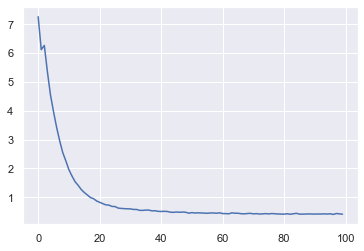

In [34]:
hyperparams = Hyperparams(embed_size=250, hidden_size=250, num_layers=1,
                          loss_func=nn.CrossEntropyLoss,
                          learning_rate=0.03, optimizer=optim.Adam, batch_size=250)

dataloader, model, optimizer, criterion = initialize_data_model_optim_loss(hyperparams)

train(100, dataloader, model, criterion, optimizer)
#model = torch.load('gru-model.pth')

In [38]:
for _ in range(10):
    generate_example(model, temperature=0.7)

<s> now , the relation between the phenomena is random iff the prob- ability of x , for that subset of events where y does hold , is identical to its probability for the subset where y does not hold , that is p ( x|y ) ⫽ p ( x|ÿ y ) the relation is symmetric : p ( x|y ) ⫽ p ( x|ÿ y ) entails p ( y|x ) ⫽ p ( y|ÿ x ) . </s>
<s> hypoth- esis testing is rarely useful for distinguishing associated from non-associ- ated pairs of phenomena in large corpora . </s>
<s> hypothesis testing has been called pointwise mutual information . </s>
<s> korhonen , anna 2000 using semantically motivated estimates to help subcategorization acquisition . </s>
<s> rather , the objection is that the probability model , with its assumptions of randomness , is inappropriate , particularly where counts are high ( eg , thousands or more ) . </s>
<s> hypothesis tests are inappropriate for the task , because the relations between verb and scf will never be random and the hypothesis test will merely reject the null h

In [39]:
import json
torch.save(model.state_dict(), 'gru-model.pth')

hyperparams_str = Hyperparams(embed_size=250, hidden_size=250, num_layers=1,
                          loss_func='nn.CrossEntropyLoss',
                          learning_rate=0.03, optimizer='optim.Adam', batch_size=250)

with open('gru-model.json', 'w') as fout:
    json.dump(dict(hyperparams_str._asdict()), fout)

In [2]:
import torch